In [8]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from astropy.table import Table
import astropy.units as u
import astropy.constants as c

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 100
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c

from scipy import interpolate
from scipy import stats
#from sklearn import svm

# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="../data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    #df.columns = df.columns.str.lower()
    return 

#Suppressing astropy units warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppressing Pandas chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Set the plot styles

In [9]:
import seaborn as sns

sns.set(style="ticks", 
        context="paper",
        font_scale=1,
        palette=sns.color_palette("coolwarm"))

sc_kws = {"cmap": "viridis", 
          "s": 10, 
          "rasterized":True, 
          "lw": 0.25, 
          "alpha": 1}

#ebar_kws = {}
#hist_kws = {}

In [10]:
df = pd.read_parquet("./data.parquet")
df.head()

,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,bf18_e_[Na/N],bf18_[Na/C],bf18_e_[Na/C],bf18_[O/N],bf18_e_[O/N],bf18_[O/C],bf18_e_[O/C],bf18_[N/C],bf18_e_[N/C],bf18_[alpha/Fe]
0,10797460,K00752.01,Kepler-227 b,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,0.155563,-0.04,0.056569,0.1,0.155563,0.08,0.056569,-0.02,0.056569,-0.01
1,10797460,K00752.02,Kepler-227 c,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,0.155563,-0.04,0.056569,0.1,0.155563,0.08,0.056569,-0.02,0.056569,-0.01
2,10811496,K00753.01,None,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10848459,K00754.01,None,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


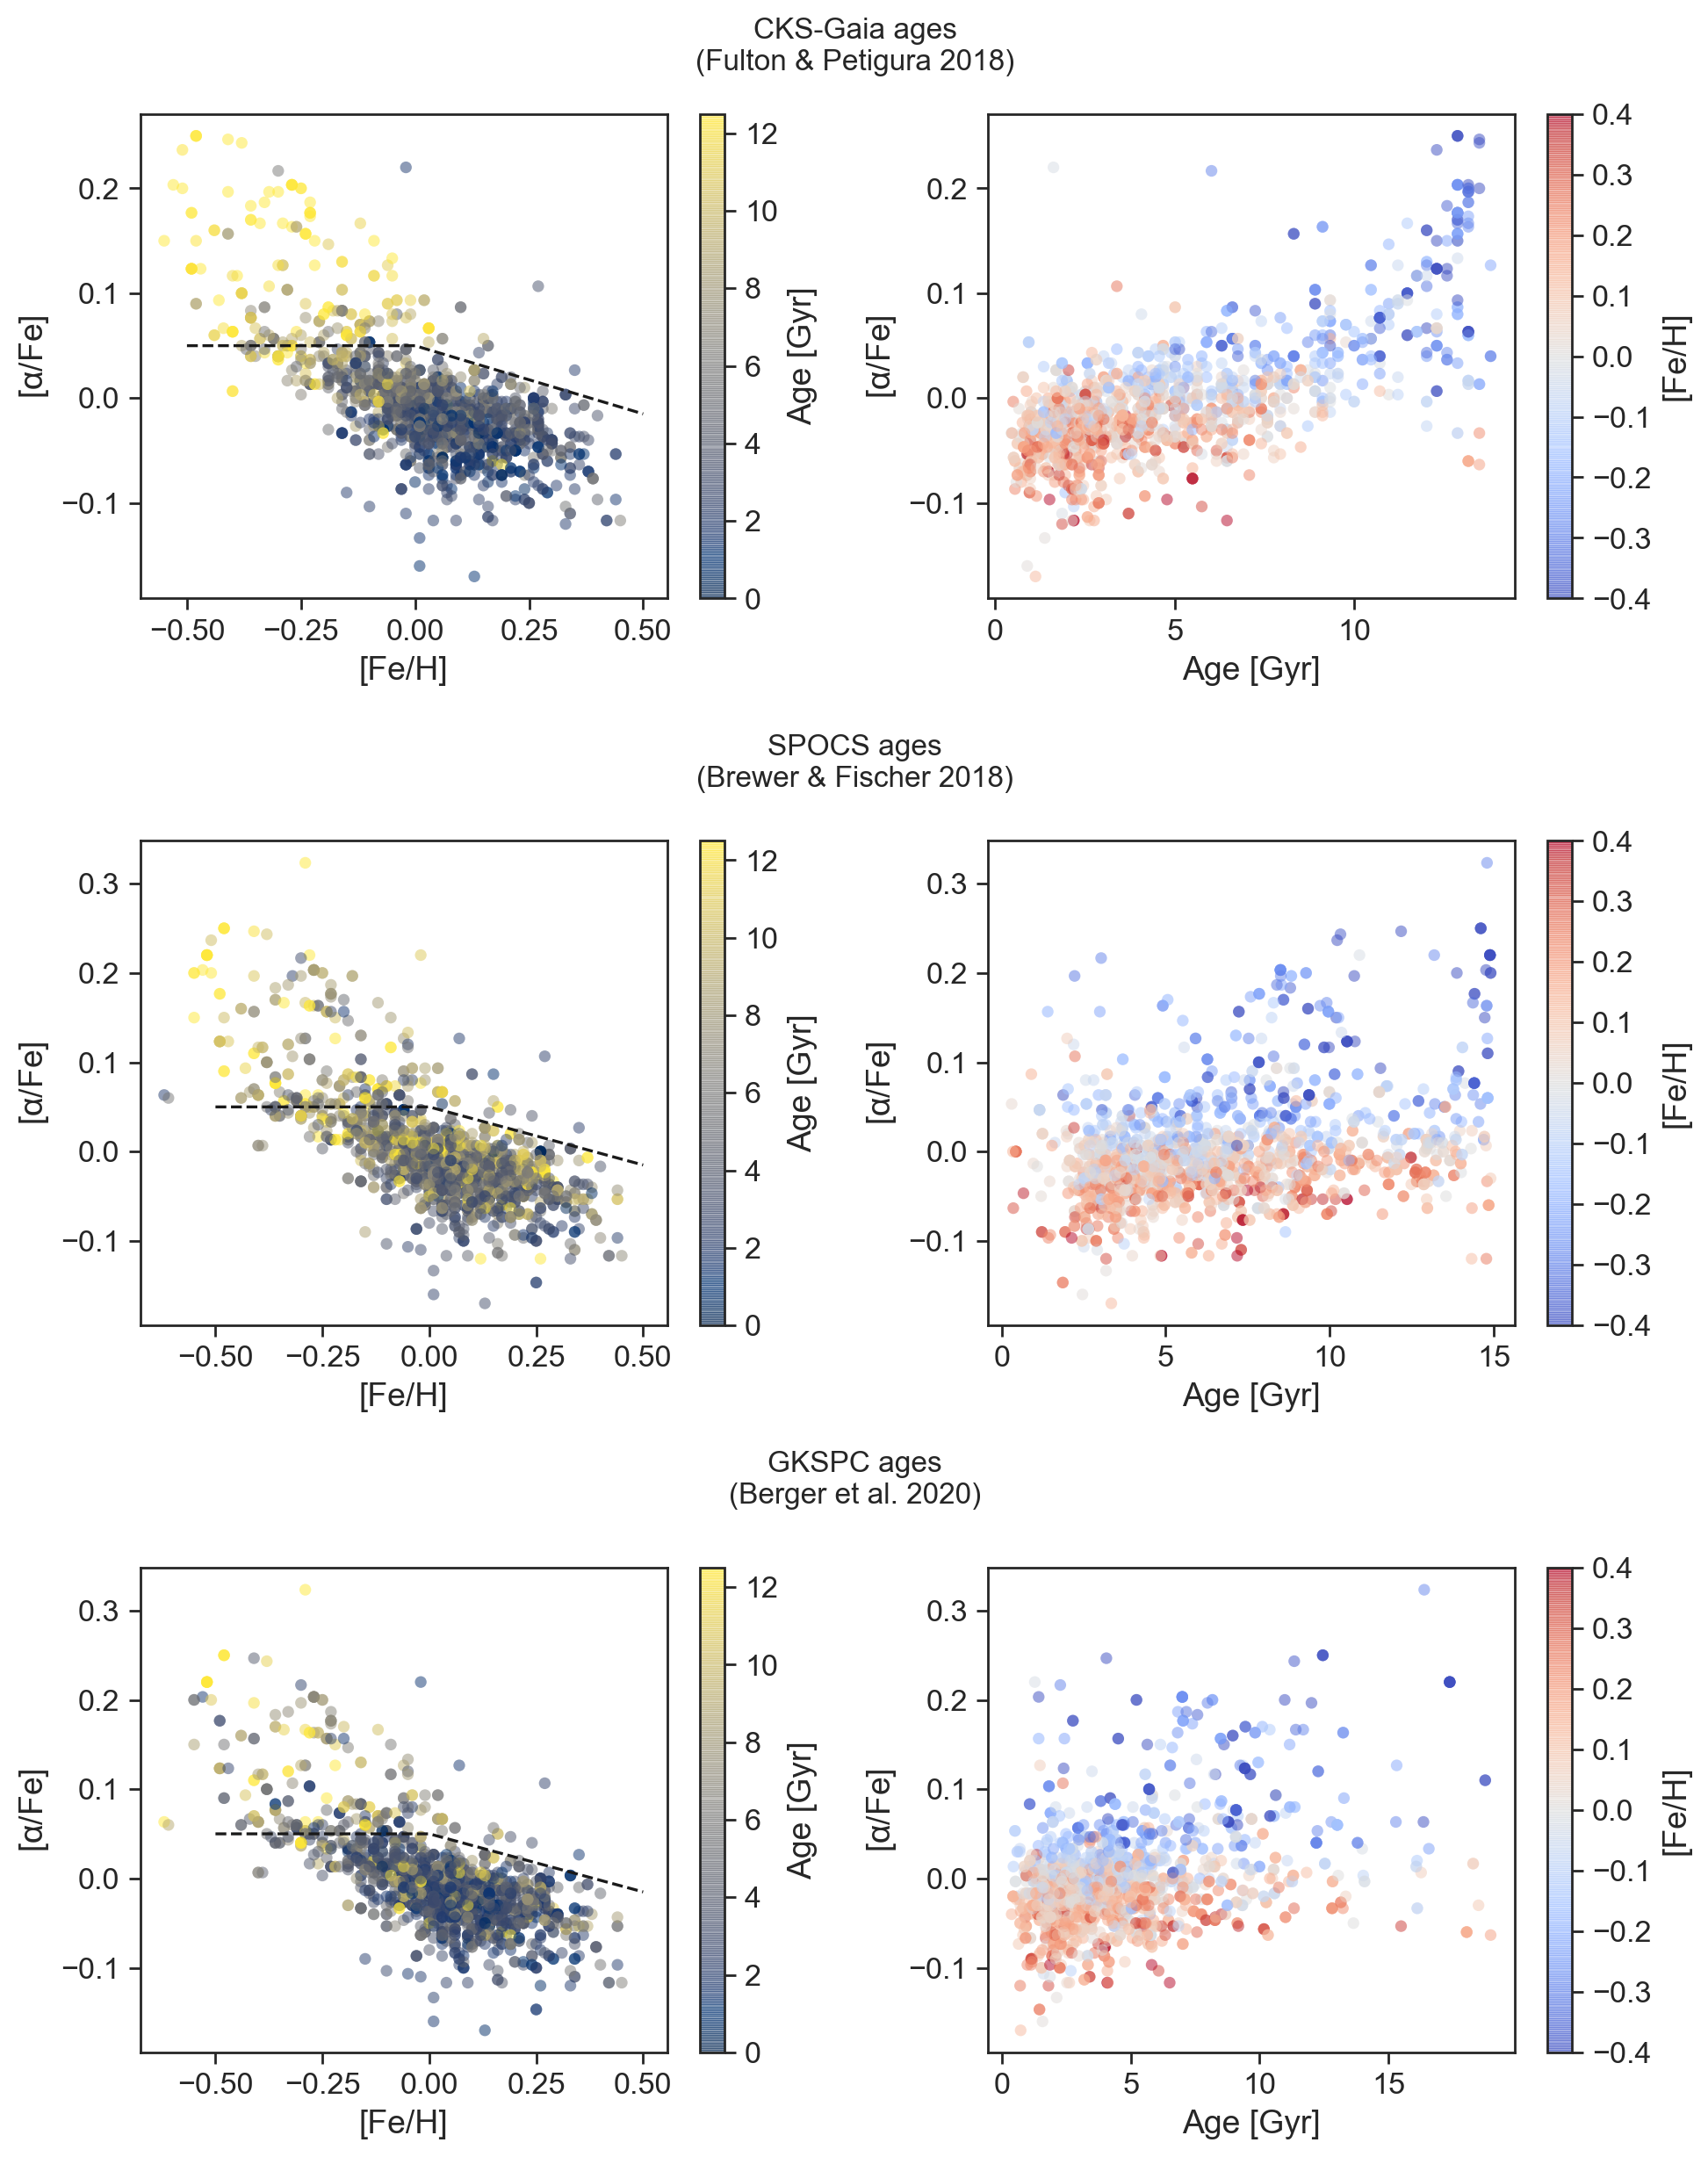

In [23]:
sns.set(font_scale=1.4, style='ticks', context='paper')

ages = [df["cks_age"],
        df["bf18_Age"],
        df["b20_iso_age"]]

age_labels = ['CKS-Gaia ages\n(Fulton & Petigura 2018)',
              'SPOCS ages\n(Brewer & Fischer 2018)',
              'GKSPC ages\n(Berger et al. 2020)']


fig,ax = plt.subplots(nrows=len(ages), ncols=2, figsize=(10,4*len(ages)))

for i,age in enumerate(ages):
    sc1 = ax[i][0].scatter(df["bf18_[Fe/H]"], 
                       df["bf18_[alpha/Fe]"], lw=0, alpha=0.5,
                       c=age, cmap='cividis', vmin=0, vmax=12.5, rasterized=True)
    
    sc2 = ax[i][1].scatter(age, 
                       df["bf18_[alpha/Fe]"], lw=0, alpha=0.5,
                       c=df["bf18_[Fe/H]"], cmap='coolwarm', vmin=-0.4, vmax=0.4, rasterized=True)    
    
    cb1 = fig.colorbar(sc1, ax=ax[i][0])
    cb2 = fig.colorbar(sc2, ax=ax[i][1])
    
    cb1.set_label("Age [Gyr]")
    cb2.set_label("[Fe/H]")
    
    ax[i][0].set_xlabel('[Fe/H]')
    ax[i][1].set_xlabel('Age [Gyr]')
    
    ax[i][0].set_ylabel(r'[$\mathregular{\alpha}$/Fe]')
    ax[i][1].set_ylabel(r'[$\mathregular{\alpha}$/Fe]')
    ax[i][0].plot([-0.5,0,0.5],[0.05,0.05,-0.015], 'k--')
    
    
    plt.figtext(0.5, 1.01-0.34*i, age_labels[i], va="center", ha="center", size=12)
    

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.savefig('./figures/alpha.pdf')
plt.show()

In [ ]:
#Note: SVMs could be a good approach for classifying stars in higher dimensions than just Fe/H vs. alpha/Fe